Tutorial on Computing HFOs
==========================

In this tutorial, we will walk through how to compute HFOs on a sample dataset that is defined in [1]. 

We will demonstrate usage of the following detectors:

- Line Length detector
- RMS detector
- Morphology detector (used in the paper)

Dataset Preprocessing
---------------------
Note that the data has been converted to BIDS to facilitate easy loading using ``mne-bids`` package. Another thing to note is that the authors in this dataset 
reported HFOs detected using bipolar montage. In addition, they only analyzed HFOs for a subset of the recording channels.

In order to compare results to a monopolar reference, we define an HFO to be "found" if there was an HFO in either of the corresponding bipolar contacts.

References
----------
[1] Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient.
Scientific Reports. 2017;7(1):13836.
https://www.nature.com/articles/s41598-017-13064-1
doi:10.1038/s41598-017-13064-1

In [24]:
# first let's load in all our packages
import numpy as np
import sys

from mne_bids import (read_raw_bids, BIDSPath, 
                      get_entity_vals, get_datatypes, 
                      make_report)
from mne_bids.stats import count_events

sys.path.append('../../')
from mne_hfo import LineLengthDetector, RMSDetector

Define dataset paths and load the data
--------------------------------------

The data is assumed to be in BIDS format. We have converted the dataset into BIDS, 
which you can load using [mne-bids](https://github.com/mne-tools/mne-bids).

In [7]:
# this may change depending on where you store the data
root = '/Users/adam2392/Dropbox/fedele_hfo_data/'

In [9]:
# print a boiler plate summary report using mne-bids
report = make_report(root, verbose=False)
print(report)

Summarizing participants.tsv /Users/adam2392/Dropbox/fedele_hfo_data/participants.tsv...
The Fedele-epilepsy-HFO-iEEG Dataset dataset was created with BIDS version 1.4.0
by Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, and
Sarnthein J. This report was generated with MNE-BIDS
(https://doi.org/10.21105/joss.01896). The dataset consists of 20 participants
(comprised of 14 men and 6 women; handedness were all unknown; ages ranged from
17.0 to 52.0 (mean = 32.1, std = 11.26))and 1 recording sessions:
interictalsleep. Data was recorded using a iEEG system (Neuralynx manufacturer)
sampled at 2000.0 Hz with line noise at 50.0 Hz using Sampling with parameters
2000 Downsampled (Hz). There were 385 scans in total. Recording durations ranged
from 204.0 to 720.0 seconds (mean = 302.44, std = 37.85), for a total of
116438.81 seconds of data recorded over all scans. For each dataset, there were
on average 51.88 (std = 15.55) recording channels per scan, out of which 51.88
(std =

In [13]:
# there are iEEG datatypes throughout the dataset
datatypes = get_datatypes(root)
print(datatypes)

# get all the subjects, sessions
subjects = get_entity_vals(root, 'subject')
sessions = get_entity_vals(root, 'session')

print(subjects)
print(sessions)

['ieeg']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
['interictalsleep']


In [17]:
# construct BIDSPath for dataset we will demo
bids_path = BIDSPath(subject='01', session='interictalsleep',
                     datatype='ieeg', 
                     suffix='ieeg',
                     extension='.vhdr', root=root)

# get all matching datasets
fpaths = bids_path.match()

print(f'Found {len(fpaths)} matching filepaths for this subject and session.')

Found 28 matching filepaths for this subject and session.


In [20]:
# analyze the first run
dataset_path = fpaths[0]
print(dataset_path)

# count the different HFO types (fr, ripple, frandr) that were detected using 
# the published Morphology detector
counts_df = count_events(dataset_path)
display(counts_df)

/Users/adam2392/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_ieeg.vhdr


NaN                                        \
trial_type                  fr_AHR1-2 fr_AHR2-3 fr_AHR3-4 fr_AL1-2 fr_AL2-3   
subject session         run                                                   
01      interictalsleep 01         15        23        12       15       19   

                                                                          ...  \
trial_type                  fr_AL3-4 fr_AR1-2 fr_AR2-3 fr_AR3-4 fr_HL1-2  ...   
subject session         run                                               ...   
01      interictalsleep 01        20       25       28       11        9  ...   

                                                                       \
trial_type                  ripple_IAR2-3 ripple_IAR3-4 ripple_IAR4-5   
subject session         run                                             
01      interictalsleep 01            351           223           179   

                                                                       \
trial_type                  ripple_IAR5-6 ripple_IPR1-2 ripple_IPR2-3   
subject session         run                                             
01      interictalsleep 01            238            12            32   

                                                                       \
trial_type                  ripple_IPR3-4 ripple_PHR1-2 ripple_PHR2-3   
subject session         run                                             
01      interictalsleep 01            128           121           111   

                                           
trial_type                  ripple_PHR3-4  
subject session         run                
01      interictalsleep 01             64  

[1 rows x 60 columns]

In [21]:
# load dataset into mne Raw object
raw = read_raw_bids(dataset_path)
print(raw)

Extracting parameters from /Users/adam2392/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/fedele_hfo_data/sub-01/ses-interictalsleep/ieeg/sub-01_ses-interictalsleep_run-01_channels.tsv.
<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 50 x 600000 (300.0 s), ~56 kB, data not loaded>


<ipython-input-21-dd941634114c>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(dataset_path)
<ipython-input-21-dd941634114c>:1: RuntimeWarning: Did not find any electrodes.tsv associated with sub-01_ses-interictalsleep_run-01.

The search_str was "/Users/adam2392/Dropbox/fedele_hfo_data/sub-01/**/sub-01_ses-interictalsleep*electrodes.tsv"
  raw = read_raw_bids(dataset_path)
<ipython-input-21-dd941634114c>:1: RuntimeWarning: Did not find any coordsystem.json associated with sub-01_ses-interictalsleep_run-01.

The search_str was "/Users/adam2392/Dropbox/fedele_hfo_data/sub-01/**/sub-01_ses-interictalsleep*coordsystem.json"
  raw = read_raw_bids(dataset_path)


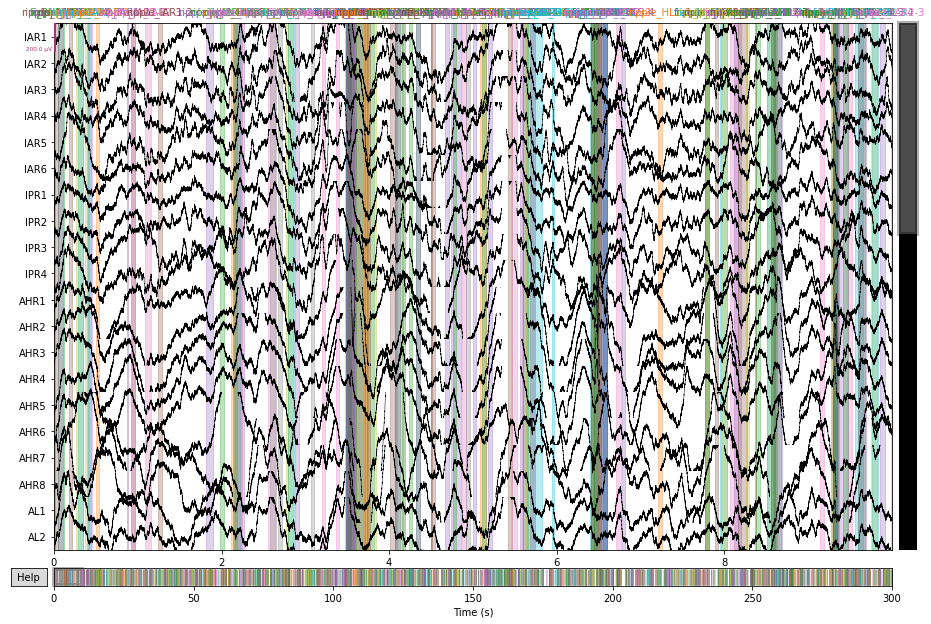

plotting channels with HFO events detected in the original publication in color.


In [25]:
raw.plot()
print('plotting channels with HFO events detected in '
      'the original publication in color.')

In [32]:
print(f'Data has sampling rate of {raw.info["sfreq"]} Hz')

Data has sampling rate of 2000.0 Hz


Line Length Detector
--------------------

In [33]:
kwargs = {
    'l_freq': 80,
    'h_freq': 500,
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
}
detector = LineLengthDetector(**kwargs)

In [34]:
chs_hfo = detector.fit(raw)

TypeError: compute_line_length() got an unexpected keyword argument 'win_size'

RMS Detector
------------

In [35]:
kwargs = {
    'l_freq': 80,
    'h_freq': 500,
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
}
detector = RMSDetector(**kwargs)

In [36]:
chs_hfo = detector.fit(raw)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Reproducing Results Using Morphology Detector

Here, we will reproduce to the best of our ability the results published using the morphology detector. We will show the results on the bipolar reference and also compare to the published results only using the subset of channels they selected.

Later on, we will then show the results for the other channels. 

In [ ]:
# detector parameters